Importing Libraries

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from better_velocity import extract_puberty_features
from clean_parent import clean_parent, clean_child
from plot_vel import plot_velocity_curves1

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from scipy.stats import ttest_rel, wilcoxon

from sklearn.linear_model import LinearRegression


Importing and cleaning raw datasets

In [2]:
path = "../adv-ml-2025/gen1_train_comp_final.csv"
parent_wide, parent_long = clean_parent(path)

path = "../adv-ml-2025/gen2_train_comp_final.csv"
child_wide, child_long, child2parent, parent2sex, child2sex = clean_child(path)

Adding back in gender and parent id

In [3]:
child_wide.loc[:, "sex"] = child_wide.index.map(child2sex)
child_wide.loc[:, "gen1_id"] = child_wide.index.map(child2parent)
child_wide.loc[:, "parent_sex"] = child_wide.loc[:,"gen1_id"].map(parent2sex)

plotting two children velocity curves

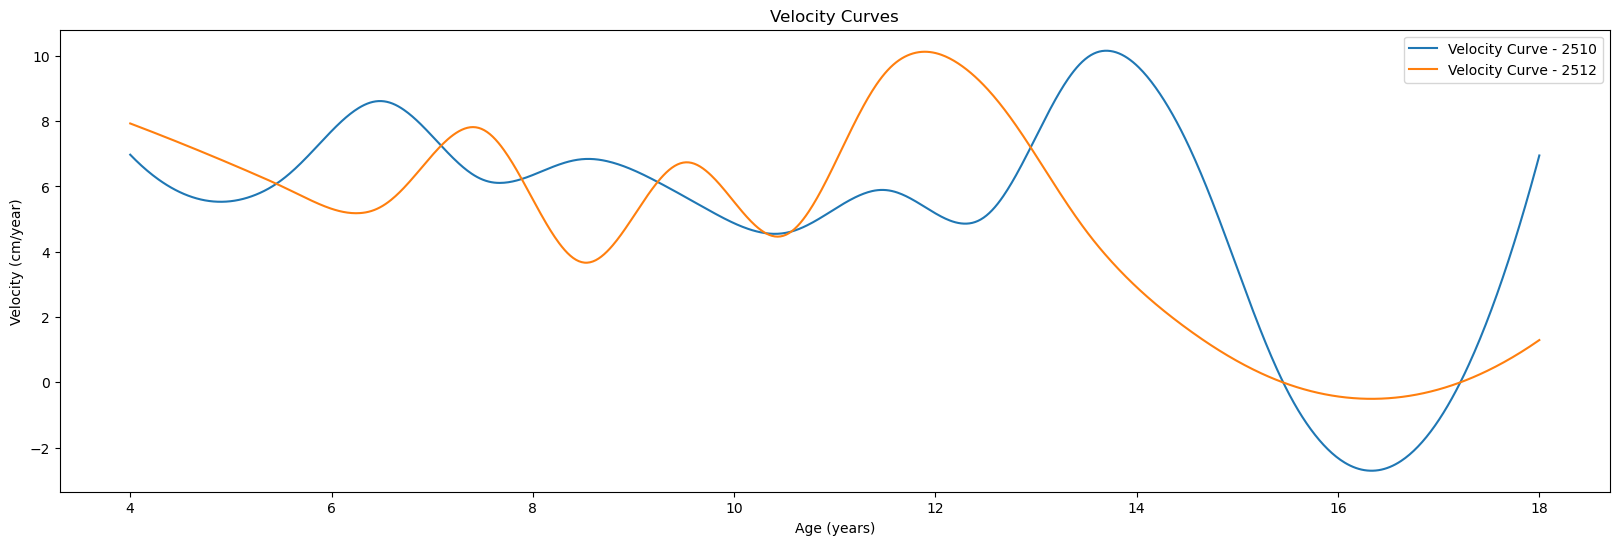

In [4]:
plot_velocity_curves1(child_wide, 1, 2)

Getting the features we need from the children

In [5]:
puberty_df = extract_puberty_features(child_wide.iloc[:, 8:22])

In [6]:
puberty_df.head()

,PHV,Age_at_PHV,Age_at_Onset,Age_at_End,Duration
id,,,,,
2509,9.572782,10.922923,9.465465,13.781782,4.316316
2510,10.153914,13.697698,12.296296,18.000000,5.703704
2512,10.122559,11.889890,10.432432,18.000000,7.567568
2513,9.638962,13.529530,11.637638,18.000000,6.362362
2514,14.184588,14.426426,12.996997,18.000000,5.003003


Adding gender back in

In [7]:
puberty_df.loc[:, "sex"] = puberty_df.index.map(child2sex)
puberty_df.loc[:, "gen1_id"] = puberty_df.index.map(child2parent)
puberty_df.loc[:, "parent_sex"] = puberty_df.loc[:,"gen1_id"].map(parent2sex)

Merging with parent info

In [8]:
merged_df = puberty_df.merge(
    parent_wide, left_on="gen1_id", right_index=True, how="left"
).dropna()

parent_puberty_df = extract_puberty_features(parent_wide.iloc[:, 8:36])

parent_puberty_df = parent_puberty_df.rename(columns={k: "parent_"+k for k in parent_puberty_df.columns.to_list()})

merged_df = merged_df.merge(parent_puberty_df, left_on="gen1_id", right_index=True, how = "left")

In [9]:
merged_df.head()

,PHV,Age_at_PHV,Age_at_Onset,Age_at_End,Duration,sex,gen1_id,parent_sex,0.1,0.25,...,18.0,18.5,19.0,19.5,20.0,parent_PHV,parent_Age_at_PHV,parent_Age_at_Onset,parent_Age_at_End,parent_Duration
id,,,,,,,,,,,,,,,,,,,,,
2509,9.572782,10.922923,9.465465,13.781782,4.316316,F,694,M,55.826458,63.402308,...,187.320811,187.306432,187.292054,187.700016,188.107978,11.080121,12.616617,10.870871,13.305305,2.434434
2510,10.153914,13.697698,12.296296,18.000000,5.703704,M,383,M,57.149109,65.915863,...,194.970999,195.092417,195.213834,195.464294,195.714755,9.683525,13.417417,12.824825,14.106106,1.281281
2513,9.638962,13.529530,11.637638,18.000000,6.362362,F,539,M,53.935810,60.679808,...,182.991174,183.055302,184.778050,184.384969,185.051548,11.544783,14.954955,14.170170,15.707708,1.537538
2514,14.184588,14.426426,12.996997,18.000000,5.003003,M,469,M,56.888647,61.649094,...,188.761179,189.732545,191.797827,192.428120,193.183434,6.703235,8.004004,8.000000,8.964965,0.964965
2515,7.181446,8.680681,8.000000,9.605606,1.605606,F,576,M,58.514945,64.128871,...,189.772037,189.939614,190.502810,191.041194,191.686232,8.295496,13.961962,12.280280,18.000000,5.719720


Making gender 1 or 0

In [10]:
merged_df["parent_sex"] = merged_df["parent_sex"].map({"F": 0, "M": 1})
merged_df["sex"] = merged_df["sex"].map({"F": 0, "M": 1})

Finding which parent heights are most correlated with Duration

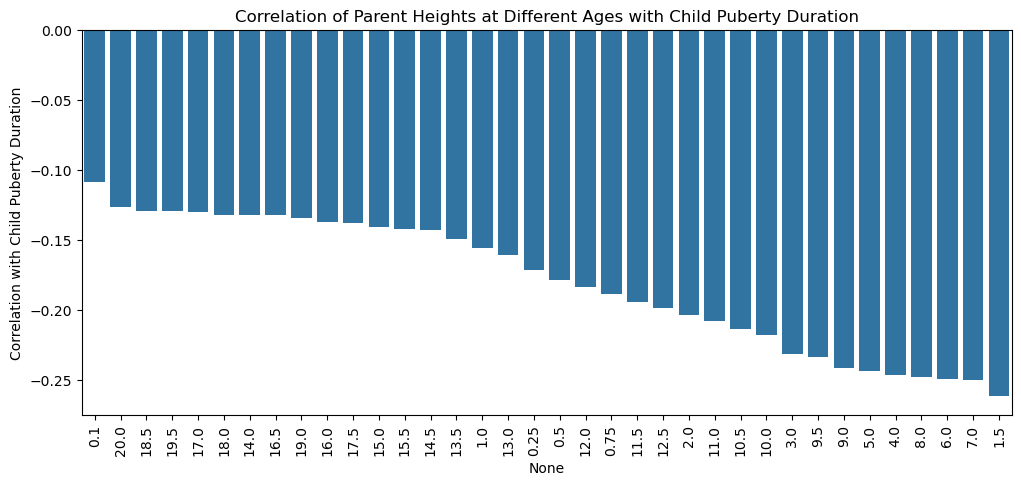

In [11]:
# Select all parent heights
parent_height_cols = merged_df.iloc[:, 8:44].columns.to_list()

# Compute correlation with child's final height
correlations = merged_df[["Duration"] + parent_height_cols].corr()

# Extract only the correlations between parent heights and child final height
corr_target = correlations["Duration"].drop("Duration").sort_values(ascending=False)

# Ensure sorting is explicitly applied in seaborn
plt.figure(figsize=(12, 5))
sns.barplot(x=corr_target.index, y=corr_target.values, order=corr_target.index)
plt.xticks(rotation=90)
plt.ylabel("Correlation with Child Puberty Duration")
plt.title("Correlation of Parent Heights at Different Ages with Child Puberty Duration")
plt.show()

Choosing only parent ages that are correlated with child puberty duration

In [12]:
threshold = 0.22  # Set your desired threshold

high_corr_target = corr_target[
    corr_target.abs() > threshold
]


Predicting Puberty Duration with correlated parent heights

Linear Regression R² Score: -0.359
Mean Absolute Error (MAE): 2.08 cm
Root Mean Squared Error (RMSE): 2.40 cm


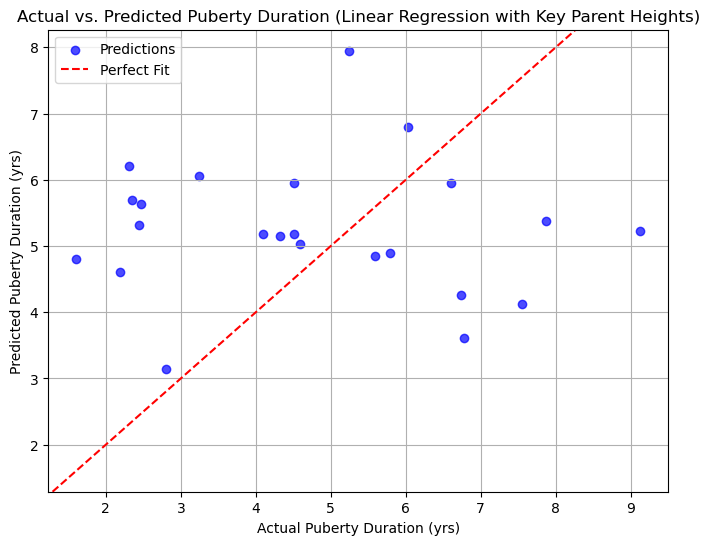

In [13]:
key_ages = high_corr_target.index.to_list() + ["parent_PHV", "parent_Duration", "parent_Age_at_PHV"]

X = merged_df[key_ages]  # Parent heights at key ages
X.columns = X.columns.astype(str)
y = merged_df["Duration"]  # Child's duration

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lin_model.predict(X_test)
r2_lin = r2_score(y_test, y_pred)
mae_lin = mean_absolute_error(y_test, y_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression R² Score: {r2_lin:.3f}")
print(f"Mean Absolute Error (MAE): {mae_lin:.2f} cm")
print(f"Root Mean Squared Error (RMSE): {rmse_lin:.2f} cm")

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.axline((min(y_test), min(y_test)), slope=1, linestyle='--', color='red', label="Perfect Fit")
plt.xlabel("Actual Puberty Duration (yrs)")
plt.ylabel("Predicted Puberty Duration (yrs)")
plt.title("Actual vs. Predicted Puberty Duration (Linear Regression with Key Parent Heights)")
plt.legend()
plt.grid()
plt.show()

Doing the same for Age when puberty starts

In [14]:
# Select all parent heights
parent_height_cols = merged_df.iloc[:, 8:44].columns.to_list()

# Compute correlation with child's final height
correlations = merged_df[["Age_at_Onset"] + parent_height_cols].corr()

# Extract only the correlations between parent heights and child final height
corr_target = correlations["Age_at_Onset"].drop("Age_at_Onset").sort_values(ascending=True)

In [15]:
corr_target

11.5   -0.117486
12.0   -0.116848
16.0   -0.111959
14.5   -0.106773
15.0   -0.104900
14.0   -0.100947
15.5   -0.100377
12.5   -0.098004
16.5   -0.094305
17.0   -0.090929
13.0   -0.090844
0.25   -0.089679
13.5   -0.088113
11.0   -0.084225
18.5   -0.080965
10.5   -0.080532
17.5   -0.080336
18.0   -0.076326
19.0   -0.075692
19.5   -0.074695
10.0   -0.074131
7.0    -0.070174
20.0   -0.070073
8.0    -0.069521
4.0    -0.063298
0.75   -0.058588
9.0    -0.057828
9.5    -0.055066
5.0    -0.053640
1.5    -0.053422
1.0    -0.052508
0.5    -0.042706
3.0    -0.038952
6.0    -0.035281
0.1    -0.012452
2.0     0.016224
Name: Age_at_Onset, dtype: float64

In [16]:
threshold = 0.095  # Set your desired threshold

high_corr_target = corr_target[
    corr_target.abs() > threshold
]

Linear Regression R² Score: -0.274
Mean Absolute Error (MAE): 1.74 cm
Root Mean Squared Error (RMSE): 2.06 cm


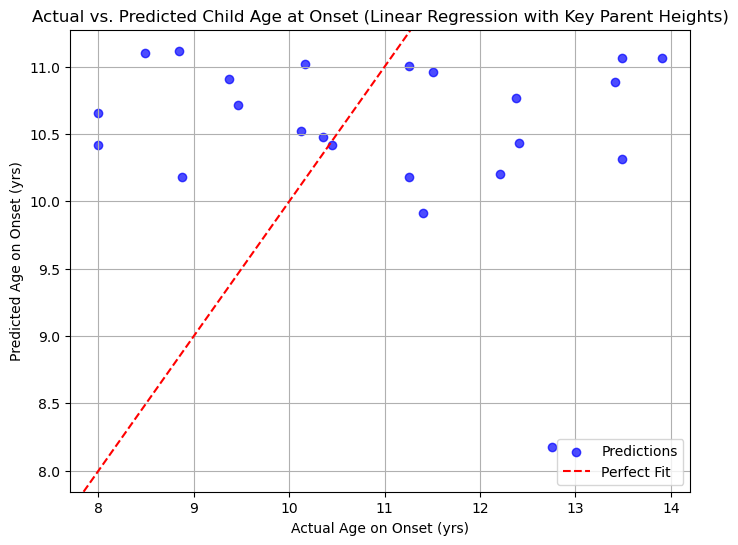

In [17]:
key_ages = high_corr_target.index.to_list() + ["parent_PHV", "parent_Duration", "parent_Age_at_PHV"]

X = merged_df[key_ages]  # Parent heights at key ages
X.columns = X.columns.astype(str)
y = merged_df["Age_at_Onset"]  # Child's onset age

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression Model
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = lin_model.predict(X_test)
r2_lin = r2_score(y_test, y_pred)
mae_lin = mean_absolute_error(y_test, y_pred)
rmse_lin = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression R² Score: {r2_lin:.3f}")
print(f"Mean Absolute Error (MAE): {mae_lin:.2f} cm")
print(f"Root Mean Squared Error (RMSE): {rmse_lin:.2f} cm")

# Plot Actual vs. Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color="blue", label="Predictions")
plt.axline((min(y_test), min(y_test)), slope=1, linestyle='--', color='red', label="Perfect Fit")
plt.xlabel("Actual Age on Onset (yrs)")
plt.ylabel("Predicted Age on Onset (yrs)")
plt.title("Actual vs. Predicted Child Age at Onset (Linear Regression with Key Parent Heights)")
plt.legend()
plt.grid()
plt.show()

Splitting into parent gender to child gender, four groups

In [18]:
# Split into four groups based on parent-child sex combinations
father_son = merged_df[(merged_df["parent_sex"] == 1) & (merged_df["sex"] == 1)]
father_daughter = merged_df[(merged_df["parent_sex"] == 1) & (merged_df["sex"] == 0)]
mother_son = merged_df[(merged_df["parent_sex"] == 0) & (merged_df["sex"] == 1)]
mother_daughter = merged_df[(merged_df["parent_sex"] == 0) & (merged_df["sex"] == 0)]

# Display the number of samples in each group
print(f"Father → Son: {father_son.shape[0]} samples")
print(f"Father → Daughter: {father_daughter.shape[0]} samples")
print(f"Mother → Son: {mother_son.shape[0]} samples")
print(f"Mother → Daughter: {mother_daughter.shape[0]} samples")

Father → Son: 31 samples
Father → Daughter: 28 samples
Mother → Son: 23 samples
Mother → Daughter: 29 samples


Make a function to train and evaluate model for each of the four possibilities

In [19]:
def train_model(df, y_col, label, key_ages):
    """Trains and evaluates a linear regression model for each parent-child combination."""
    X = df[key_ages]
    X.columns = X.columns.astype(str)
    y = df[y_col]

    # Train-test split (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predict and evaluate performance
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_pred, y_test))
    mae = mean_absolute_error(y_pred, y_test)
    r2 = r2_score(y_test, y_pred)
    print(f"{label} R² Score: {r2:.3f}")
    print(f"rmse = {rmse}")
    print(f"mae = {mae} \n")

In [20]:
# Select all parent heights
parent_height_cols = merged_df.iloc[:, 8:44].columns.to_list()

# Compute correlation with child's final height
correlations = merged_df[["Age_at_Onset"] + parent_height_cols].corr()

# Extract only the correlations between parent heights and child final height
corr_target = correlations["Age_at_Onset"].drop("Age_at_Onset").sort_values(ascending=True)


In [21]:
corr_target

11.5   -0.117486
12.0   -0.116848
16.0   -0.111959
14.5   -0.106773
15.0   -0.104900
14.0   -0.100947
15.5   -0.100377
12.5   -0.098004
16.5   -0.094305
17.0   -0.090929
13.0   -0.090844
0.25   -0.089679
13.5   -0.088113
11.0   -0.084225
18.5   -0.080965
10.5   -0.080532
17.5   -0.080336
18.0   -0.076326
19.0   -0.075692
19.5   -0.074695
10.0   -0.074131
7.0    -0.070174
20.0   -0.070073
8.0    -0.069521
4.0    -0.063298
0.75   -0.058588
9.0    -0.057828
9.5    -0.055066
5.0    -0.053640
1.5    -0.053422
1.0    -0.052508
0.5    -0.042706
3.0    -0.038952
6.0    -0.035281
0.1    -0.012452
2.0     0.016224
Name: Age_at_Onset, dtype: float64

In [22]:
threshold = 0.095  # Set your desired threshold

# Filter correlations above the threshold
high_corr_target = corr_target[
    corr_target.abs() > threshold
]  # Use abs() if you care about both positive & negative correlations

key_ages = high_corr_target.index.to_list() + ["parent_PHV", "parent_Duration", "parent_Age_at_PHV"]

Models do very poorly, don't even need to check for statistical significance, we know they don't perform better than just predicting the mean

In [23]:
train_model(father_son, "Age_at_Onset", "Father → Son", key_ages)
train_model(father_daughter, "Age_at_Onset", "Father → Daughter", key_ages)
train_model(mother_son, "Age_at_Onset", "Mother → Son", key_ages)
train_model(mother_daughter, "Age_at_Onset", "Mother → Daughter", key_ages)

Father → Son R² Score: -2.791
rmse = 3.310495950703774
mae = 2.61728966899112 

Father → Daughter R² Score: -2.131
rmse = 1.315127280649571
mae = 1.1220907646394698 

Mother → Son R² Score: -4.868
rmse = 2.26927574994159
mae = 1.586340943044006 

Mother → Daughter R² Score: -2.343
rmse = 1.816998532710436
mae = 1.4876857362100608 



In [24]:
# Select all parent heights
parent_height_cols = merged_df.iloc[:, 8:44].columns.to_list()

# Compute correlation with child's final height
correlations = merged_df[["Duration"] + parent_height_cols].corr()

# Extract only the correlations between parent heights and child final height
corr_target = correlations["Duration"].drop("Duration").sort_values(ascending=True)

In [25]:
corr_target

1.5    -0.261723
7.0    -0.250218
6.0    -0.249008
8.0    -0.248152
4.0    -0.246162
5.0    -0.243461
9.0    -0.241601
9.5    -0.233606
3.0    -0.231800
10.0   -0.218080
10.5   -0.213326
11.0   -0.207825
2.0    -0.203673
12.5   -0.198789
11.5   -0.194489
0.75   -0.188521
12.0   -0.183294
0.5    -0.178756
0.25   -0.171618
13.0   -0.160556
1.0    -0.156085
13.5   -0.149664
14.5   -0.143285
15.5   -0.142183
15.0   -0.141050
17.5   -0.137639
16.0   -0.136897
19.0   -0.134154
16.5   -0.132474
14.0   -0.132253
18.0   -0.132169
17.0   -0.130218
19.5   -0.129182
18.5   -0.129046
20.0   -0.126672
0.1    -0.108916
Name: Duration, dtype: float64

In [26]:
threshold = 0.24  # Set your desired threshold

# Filter correlations above the threshold
high_corr_target = corr_target[
    corr_target.abs() > threshold
]  # Use abs() if you care about both positive & negative correlations

key_ages = high_corr_target.index.to_list() + ["parent_PHV", "parent_Duration", "parent_Age_at_PHV"]

In [27]:
train_model(father_son, "Duration", "Father → Son", key_ages)
train_model(father_daughter, "Duration", "Father → Daughter", key_ages)
train_model(mother_son, "Duration", "Mother → Son", key_ages)
train_model(mother_daughter, "Duration", "Mother → Daughter", key_ages)

Father → Son R² Score: -4.511
rmse = 3.2283872647053626
mae = 2.235583952135882 

Father → Daughter R² Score: -14.656
rmse = 4.077979021638096
mae = 3.7189161165273714 

Mother → Son R² Score: -1.312
rmse = 1.4244692920679387
mae = 1.0780583781195694 

Mother → Daughter R² Score: 0.615
rmse = 1.3334011496417453
mae = 1.1791411938170968 



Mother Daughter relation may be intersting

In [29]:
df = mother_daughter.copy()
y_col = "Duration"

In [37]:
X = df[key_ages]
X.columns = X.columns.astype(str)
y = df[y_col]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


mean_final_height = y_train.mean()

# Predict this mean value for all test samples
y_pred_baseline = np.full_like(y_test, mean_final_height)
rmse = np.sqrt(mean_squared_error(y_pred_baseline, y_test))
mae = mean_absolute_error(y_pred_baseline, y_test)
r2 = r2_score(y_test, y_pred_baseline)
print(f"Mother → Daughter R² Score: {r2:.3f}")
print(f"rmse = {rmse}")
print(f"mae = {mae} \n")

Mother → Daughter R² Score: -0.019
rmse = 2.170083024772981
mae = 1.9473386429908164 



In [40]:
# Compute absolute errors
baseline_errors = np.abs(y_test - y_test.mean())  # Baseline uses mean predictor
model_errors = np.abs(y_test - y_pred)  # Our model's errors

# Paired t-test
t_stat, p_val_ttest = ttest_rel(baseline_errors, model_errors)

# Wilcoxon signed-rank test (non-parametric)
w_stat, p_val_wilcoxon = wilcoxon(baseline_errors, model_errors)

# Display results
test_results = {
    "Paired t-test": {"t-statistic": t_stat, "p-value": p_val_ttest},
    "Wilcoxon Signed-Rank Test": {"W-statistic": w_stat, "p-value": p_val_wilcoxon},
}

test_results

{'Paired t-test': {'t-statistic': -0.6682240315925305,
  'p-value': 0.5335939465436645},
 'Wilcoxon Signed-Rank Test': {'W-statistic': 8.0, 'p-value': 0.6875}}

High p-value signifies mother daughter relationship sitll wasn't intersting enough, no difference between using a model to predict y and just using the average y to predict